In [133]:
import pandas as pd
import json
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from tqdm import tqdm

In [134]:
import json
import pandas as pd

# Load the JSON file
file_path = "C:/Users/USER/Downloads/downloaded_data.json"  # Replace with your file path
with open(file_path, 'r') as file:
    data = json.load(file)

# Convert the "datetime" field to a DataFrame
df = pd.DataFrame({'datetime': data['datetime'], 'Hp60': data['Hp60']})

In [135]:
def change_time(df):
    # Remove the 'Z' and convert to Pandas datetime format
    df['datetime'] = pd.to_datetime(df['datetime'].str.replace('Z', ''))

    # Separate components
    df['date'] = df['datetime'].dt.date       # Extract date
    df['time'] = df['datetime'].dt.time       # Extract time
    df['year'] = df['datetime'].dt.year       # Extract year
    df['month'] = df['datetime'].dt.month     # Extract month
    df['day'] = df['datetime'].dt.day         # Extract day
    df['hour'] = df['datetime'].dt.hour       # Extract hour

    df = df.drop(columns=['datetime','date','time'])
    
    return df

df = change_time(df)

In [136]:
train_df = df[df['year']!=2024]
test_df = df[df['year']==2024]

# Dataloader

In [137]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [138]:
class Sliding_window(Dataset):
    def __init__(self, df, X_point, y_point):
        self.df = df
        self.X_point = X_point
        self.y_point = y_point
        self.sequence24 = []
        self.sequence6 = []
        
        counter = 1
        temp_x = []
        temp_y = []
        for idx,i in enumerate(self.df['Hp60']):
            if counter <= self.X_point:
                temp_x.append(i)
            else:
                temp_y.append(i)
            
            if (idx + 1) % (X_point + y_point) == 0:
                self.sequence24.append(temp_x)
                self.sequence6.append(temp_y)
                temp_x = []
                temp_y = []
                counter = 0
             
            counter += 1    
    
    def __len__(self):
        return len(self.sequence24)

    def __getitem__(self, idx):
        data = torch.Tensor(self.sequence24[idx])
        label = torch.Tensor(self.sequence6[idx])
        
        return data, label


In [139]:
train_dataset = Sliding_window(df=train_df,
                         X_point=24,
                         y_point=6)
test_dataset = Sliding_window(df=test_df,
                         X_point=24,
                         y_point=6)

In [140]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [141]:
x,y = train_dataset[2:5]

In [142]:
x

tensor([[0.3330, 0.0000, 0.0000, 0.3330, 0.6670, 0.0000, 0.0000, 0.0000, 0.3330,
         0.3330, 0.6670, 0.6670, 1.3330, 0.0000, 0.0000, 0.0000, 0.0000, 0.3330,
         0.6670, 0.3330, 1.3330, 1.0000, 1.0000, 0.3330],
        [0.0000, 0.3330, 0.3330, 0.3330, 0.6670, 0.6670, 2.6670, 1.6670, 2.0000,
         1.0000, 1.3330, 1.0000, 1.3330, 1.6670, 1.0000, 0.0000, 0.6670, 1.3330,
         3.0000, 4.6670, 4.0000, 3.3330, 2.6670, 1.3330],
        [3.0000, 3.6670, 3.3330, 3.3330, 3.0000, 2.3330, 4.0000, 3.3330, 3.3330,
         2.3330, 2.6670, 3.0000, 2.3330, 2.0000, 2.3330, 1.3330, 2.0000, 2.0000,
         1.6670, 1.3330, 1.3330, 1.6670, 1.6670, 1.3330]])

In [143]:
y

tensor([[0.3330, 0.0000, 0.0000, 0.3330, 0.6670, 0.0000],
        [2.0000, 1.0000, 1.3330, 2.3330, 2.6670, 4.0000],
        [1.0000, 2.0000, 1.3330, 1.6670, 2.0000, 2.0000]])

# Train

In [144]:
# class signal_model(nn.Module):
#     def __init__(self, X_point, y_point, hidden_dim):
#         super(signal_model, self).__init__()
#         self.lstm = nn.LSTM(X_point, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, y_point)
#         self.activation = nn.Softplus()
    
#     def forward(self, sentences):
#         lstm_out, _ = self.lstm(sentences)
#         #print(lstm_out.shape)
#         #lstm_out_last = lstm_out[:, -1, :]
#         #print(lstm_out_last.shape)
#         x = self.fc(lstm_out)
#         #print(x.shape)
#         x = self.activation(x)
#         return x
    

In [145]:
class GRUModel(nn.Module):
    def __init__(self, X_point, y_point, hidden_dim, num_layers=1, dropout=0.0):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, 
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, y_point)
        self.activation = nn.Softplus()

    def forward(self, inputs):
        # Ensure input has the correct dimensions
        inputs = inputs.unsqueeze(-1)  # Add feature dimension (shape: [batch_size, sequence_length, 1])
        # GRU forward pass
        gru_out, _ = self.gru(inputs)  # Outputs the hidden states for each time step
        # Take the output from the last time step
        gru_out_last = gru_out[:, -1, :]  # Get the last time step's output
        # Fully connected layer and activation
        x = self.fc(gru_out_last)
        x = self.activation(x)
        return x


In [146]:
#model = signal_model(X_point=24, y_point=6,hidden_dim=50)
model = GRUModel(X_point=24, y_point=6, hidden_dim=50, num_layers=2, dropout=0.2)


In [147]:
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)


epochs = 50

# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.
    
    train_dataloader = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}")
    for i, (inputs, futures) in enumerate(train_dataloader):
        inputs, futures = inputs, futures
        optimizer.zero_grad()  # Zero the gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, futures)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()

    print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 100:.4f}")
    running_loss = 0.0

Epoch 1/50: 100%|██████████| 28/28 [00:00<00:00, 101.74it/s]


Epoch: 1, Batch: 28, Loss: 0.3441


Epoch 2/50: 100%|██████████| 28/28 [00:00<00:00, 101.69it/s]


Epoch: 2, Batch: 28, Loss: 0.2509


Epoch 3/50: 100%|██████████| 28/28 [00:00<00:00, 106.24it/s]


Epoch: 3, Batch: 28, Loss: 0.2495


Epoch 4/50: 100%|██████████| 28/28 [00:00<00:00, 94.36it/s]


Epoch: 4, Batch: 28, Loss: 0.2523


Epoch 5/50: 100%|██████████| 28/28 [00:00<00:00, 97.28it/s]


Epoch: 5, Batch: 28, Loss: 0.2540


Epoch 6/50: 100%|██████████| 28/28 [00:00<00:00, 99.72it/s] 


Epoch: 6, Batch: 28, Loss: 0.2459


Epoch 7/50: 100%|██████████| 28/28 [00:00<00:00, 95.55it/s]


Epoch: 7, Batch: 28, Loss: 0.2431


Epoch 8/50: 100%|██████████| 28/28 [00:00<00:00, 100.53it/s]


Epoch: 8, Batch: 28, Loss: 0.2412


Epoch 9/50: 100%|██████████| 28/28 [00:00<00:00, 85.68it/s] 


Epoch: 9, Batch: 28, Loss: 0.2439


Epoch 10/50: 100%|██████████| 28/28 [00:00<00:00, 90.59it/s]


Epoch: 10, Batch: 28, Loss: 0.2412


Epoch 11/50: 100%|██████████| 28/28 [00:00<00:00, 96.99it/s]


Epoch: 11, Batch: 28, Loss: 0.2436


Epoch 12/50: 100%|██████████| 28/28 [00:00<00:00, 106.95it/s]


Epoch: 12, Batch: 28, Loss: 0.2415


Epoch 13/50: 100%|██████████| 28/28 [00:00<00:00, 98.70it/s]


Epoch: 13, Batch: 28, Loss: 0.2416


Epoch 14/50: 100%|██████████| 28/28 [00:00<00:00, 96.11it/s] 


Epoch: 14, Batch: 28, Loss: 0.2412


Epoch 15/50: 100%|██████████| 28/28 [00:00<00:00, 96.55it/s] 


Epoch: 15, Batch: 28, Loss: 0.2404


Epoch 16/50: 100%|██████████| 28/28 [00:00<00:00, 90.74it/s]


Epoch: 16, Batch: 28, Loss: 0.2396


Epoch 17/50: 100%|██████████| 28/28 [00:00<00:00, 103.28it/s]


Epoch: 17, Batch: 28, Loss: 0.2410


Epoch 18/50: 100%|██████████| 28/28 [00:00<00:00, 108.21it/s]


Epoch: 18, Batch: 28, Loss: 0.2396


Epoch 19/50: 100%|██████████| 28/28 [00:00<00:00, 108.85it/s]


Epoch: 19, Batch: 28, Loss: 0.2394


Epoch 20/50: 100%|██████████| 28/28 [00:00<00:00, 89.56it/s] 


Epoch: 20, Batch: 28, Loss: 0.2407


Epoch 21/50: 100%|██████████| 28/28 [00:00<00:00, 93.57it/s]


Epoch: 21, Batch: 28, Loss: 0.2404


Epoch 22/50: 100%|██████████| 28/28 [00:00<00:00, 86.08it/s] 


Epoch: 22, Batch: 28, Loss: 0.2392


Epoch 23/50: 100%|██████████| 28/28 [00:00<00:00, 91.00it/s]


Epoch: 23, Batch: 28, Loss: 0.2389


Epoch 24/50: 100%|██████████| 28/28 [00:00<00:00, 91.83it/s]


Epoch: 24, Batch: 28, Loss: 0.2382


Epoch 25/50: 100%|██████████| 28/28 [00:00<00:00, 106.01it/s]


Epoch: 25, Batch: 28, Loss: 0.2403


Epoch 26/50: 100%|██████████| 28/28 [00:00<00:00, 94.43it/s]


Epoch: 26, Batch: 28, Loss: 0.2382


Epoch 27/50: 100%|██████████| 28/28 [00:00<00:00, 98.41it/s]


Epoch: 27, Batch: 28, Loss: 0.2395


Epoch 28/50: 100%|██████████| 28/28 [00:00<00:00, 96.26it/s]


Epoch: 28, Batch: 28, Loss: 0.2373


Epoch 29/50: 100%|██████████| 28/28 [00:00<00:00, 101.37it/s]


Epoch: 29, Batch: 28, Loss: 0.2382


Epoch 30/50: 100%|██████████| 28/28 [00:00<00:00, 103.32it/s]


Epoch: 30, Batch: 28, Loss: 0.2366


Epoch 31/50: 100%|██████████| 28/28 [00:00<00:00, 101.84it/s]


Epoch: 31, Batch: 28, Loss: 0.2380


Epoch 32/50: 100%|██████████| 28/28 [00:00<00:00, 97.09it/s] 


Epoch: 32, Batch: 28, Loss: 0.2388


Epoch 33/50: 100%|██████████| 28/28 [00:00<00:00, 98.74it/s] 


Epoch: 33, Batch: 28, Loss: 0.2369


Epoch 34/50: 100%|██████████| 28/28 [00:00<00:00, 100.99it/s]


Epoch: 34, Batch: 28, Loss: 0.2373


Epoch 35/50: 100%|██████████| 28/28 [00:00<00:00, 90.40it/s]


Epoch: 35, Batch: 28, Loss: 0.2387


Epoch 36/50: 100%|██████████| 28/28 [00:00<00:00, 92.06it/s]


Epoch: 36, Batch: 28, Loss: 0.2374


Epoch 37/50: 100%|██████████| 28/28 [00:00<00:00, 89.06it/s]


Epoch: 37, Batch: 28, Loss: 0.2374


Epoch 38/50: 100%|██████████| 28/28 [00:00<00:00, 91.33it/s]


Epoch: 38, Batch: 28, Loss: 0.2366


Epoch 39/50: 100%|██████████| 28/28 [00:00<00:00, 96.47it/s]


Epoch: 39, Batch: 28, Loss: 0.2358


Epoch 40/50: 100%|██████████| 28/28 [00:00<00:00, 85.80it/s]


Epoch: 40, Batch: 28, Loss: 0.2376


Epoch 41/50: 100%|██████████| 28/28 [00:00<00:00, 79.40it/s]


Epoch: 41, Batch: 28, Loss: 0.2365


Epoch 42/50: 100%|██████████| 28/28 [00:00<00:00, 98.15it/s]


Epoch: 42, Batch: 28, Loss: 0.2367


Epoch 43/50: 100%|██████████| 28/28 [00:00<00:00, 93.33it/s] 


Epoch: 43, Batch: 28, Loss: 0.2349


Epoch 44/50: 100%|██████████| 28/28 [00:00<00:00, 90.78it/s]


Epoch: 44, Batch: 28, Loss: 0.2344


Epoch 45/50: 100%|██████████| 28/28 [00:00<00:00, 105.68it/s]


Epoch: 45, Batch: 28, Loss: 0.2355


Epoch 46/50: 100%|██████████| 28/28 [00:00<00:00, 96.67it/s]


Epoch: 46, Batch: 28, Loss: 0.2344


Epoch 47/50: 100%|██████████| 28/28 [00:00<00:00, 100.83it/s]


Epoch: 47, Batch: 28, Loss: 0.2341


Epoch 48/50: 100%|██████████| 28/28 [00:00<00:00, 88.00it/s]


Epoch: 48, Batch: 28, Loss: 0.2332


Epoch 49/50: 100%|██████████| 28/28 [00:00<00:00, 90.42it/s]


Epoch: 49, Batch: 28, Loss: 0.2339


Epoch 50/50: 100%|██████████| 28/28 [00:00<00:00, 97.49it/s]

Epoch: 50, Batch: 28, Loss: 0.2335


# Test

In [148]:
model.eval()

total_loss = 0
total_samples = 0

all_predictions = []
all_ground_truths = [] 
# Wrap the test dataloader with tqdm
test_dataloader = tqdm(test_dataloader, desc="Evaluation")

with torch.no_grad():
    for inputs, futures in test_dataloader:
        inputs, futures = inputs, futures
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, futures)
        total_loss += loss.item() * inputs.size(0)  # Accumulate loss
        total_samples += inputs.size(0)
        
        all_predictions.append(outputs)
        all_ground_truths.append(futures)
        
avg_loss = total_loss / total_samples
print("avg_loss",avg_loss)
print("total_loss",total_loss)
print("total_samples",total_samples)

# After the evaluation loop
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Convert saved outputs and ground truths to tensors
all_predictions = torch.cat(all_predictions, dim=0).numpy()
all_ground_truths = torch.cat(all_ground_truths, dim=0).numpy()

# Calculate MAE and MSE
mae = mean_absolute_error(all_ground_truths, all_predictions)
mse = mean_squared_error(all_ground_truths, all_predictions)

# Display metrics
print('mae:', mae)
print('mse:', mse)

Evaluation: 100%|██████████| 9/9 [00:00<00:00, 320.39it/s]

avg_loss 1.0935209443694667
total_loss 311.653469145298
total_samples 285
mae: 0.7844201
mse: 1.093521


In [149]:
print("avg_loss",avg_loss)
print("total_loss",total_loss)
print("total_samples",total_samples)

avg_loss 1.0935209443694667
total_loss 311.653469145298
total_samples 285


In [150]:
all_ground_truths

array([[2.333, 2.667, 3.   , 2.667, 1.667, 2.   ],
       [1.333, 1.333, 1.333, 1.   , 2.   , 2.   ],
       [0.667, 0.667, 0.667, 1.333, 1.   , 1.   ],
       ...,
       [1.667, 1.333, 2.667, 2.   , 1.   , 1.   ],
       [2.667, 3.667, 2.667, 2.   , 2.   , 2.333],
       [2.333, 1.667, 1.667, 1.667, 2.   , 2.667]], dtype=float32)

In [151]:
all_predictions

array([[2.9641154, 2.9964697, 2.925684 , 2.88824  , 2.7787626, 2.7840645],
       [2.8548088, 2.4523966, 2.4015148, 2.307777 , 2.3004491, 2.352857 ],
       [1.1854029, 1.2733736, 1.2391866, 1.2454447, 1.3282005, 1.4638627],
       ...,
       [1.971837 , 2.1104069, 2.055106 , 1.9183652, 2.0299466, 2.230734 ],
       [2.9504235, 2.8441694, 2.7715876, 2.7534301, 2.730087 , 2.7030692],
       [3.3265302, 3.215224 , 3.1640625, 3.132376 , 3.087572 , 3.019865 ]],
      dtype=float32)

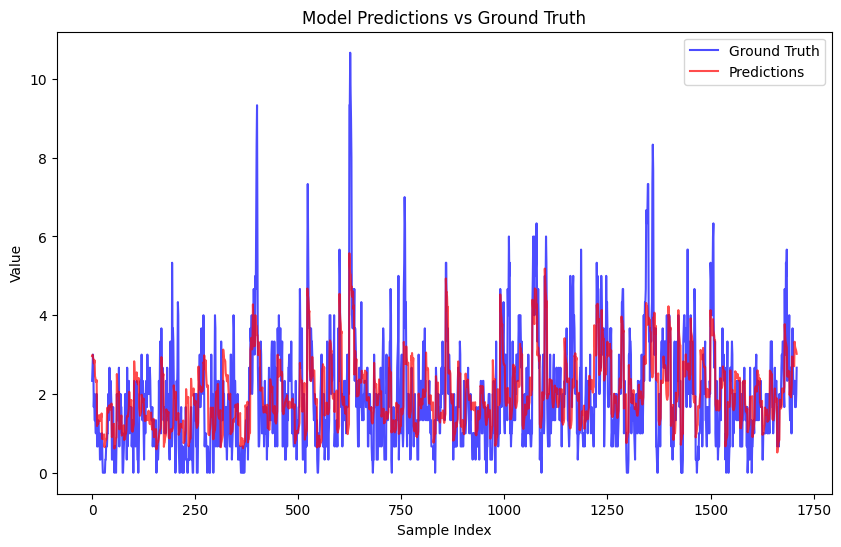

In [152]:
# Ensure all_predictions and all_ground_truths are PyTorch tensors
all_predictions = [torch.tensor(pred) if not isinstance(pred, torch.Tensor) else pred for pred in all_predictions]
all_ground_truths = [torch.tensor(gt) if not isinstance(gt, torch.Tensor) else gt for gt in all_ground_truths]

# Convert saved outputs and ground truths into tensors
all_predictions = torch.cat(all_predictions, dim=0)
all_ground_truths = torch.cat(all_ground_truths, dim=0)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(all_ground_truths.numpy().flatten(), label='Ground Truth', color='blue', alpha=0.7)
plt.plot(all_predictions.numpy().flatten(), label='Predictions', color='red', alpha=0.7)
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Model Predictions vs Ground Truth')
plt.show()